# Jonathan Halverson
# Monday, January 8, 2018
# Part 2: Detecting cluster size in an image

In [1]:
import numpy as np
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
import glob
files = np.array(glob.glob('cluster_images/*.png'))
files = np.array(glob.glob('cluster_images_concentric/*.png')) # perfect score for test set
files = np.array(glob.glob('cluster_images_no_noise/*.png'))

### Make training and test set

In [3]:
test_proportion = 0.2
ind = np.arange(files.size)
np.random.shuffle(ind)
ind_cut = int((1.0 - test_proportion) * files.size)
training_file_paths = files[ind[:ind_cut]]
testing_file_paths = files[ind[ind_cut:]]

### Examine image and create routine to generate batch

In [4]:
height = 400
width = 400

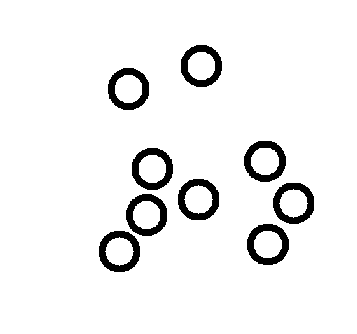

In [5]:
img_array = imageio.imread(files[1])
plt.imshow(img_array, cmap='binary')
_ = plt.axis('off')

In [6]:
def fetch_batch(file_paths, batch_size):
     A = []
     b = []
     ind = np.random.choice(np.arange(file_paths.size), size=batch_size, replace=False)
     for file_path in file_paths[ind]:
          img_array = np.array(imageio.imread(file_path)).astype(np.float32) / 255.0
          A.append(img_array)
          cluster_size = int(file_path.split('_C')[1][0])
          b.append(cluster_size)
     return np.array(A).reshape(-1, height, width, 1), np.array(b)

(array([ 146032.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,   13968.]),
 array([   0.  ,   12.75,   25.5 ,   38.25,   51.  ,   63.75,   76.5 ,
          89.25,  102.  ,  114.75,  127.5 ,  140.25,  153.  ,  165.75,
         178.5 ,  191.25,  204.  ,  216.75,  229.5 ,  242.25,  255.  ]),
 <a list of 20 Patch objects>)

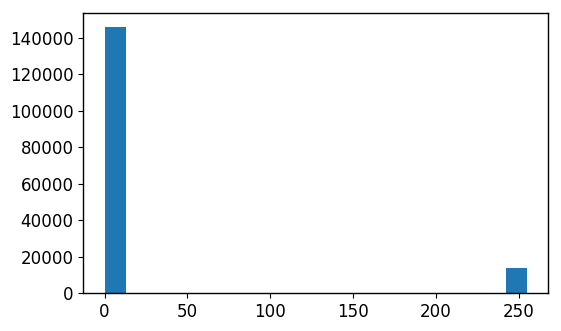

In [7]:
plt.hist(img_array.flatten(), bins=20)

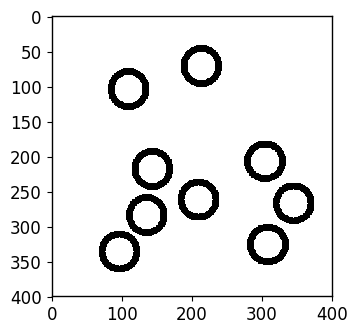

In [8]:
plt.imshow(np.where(img_array > 128, img_array, 0), cmap='binary')

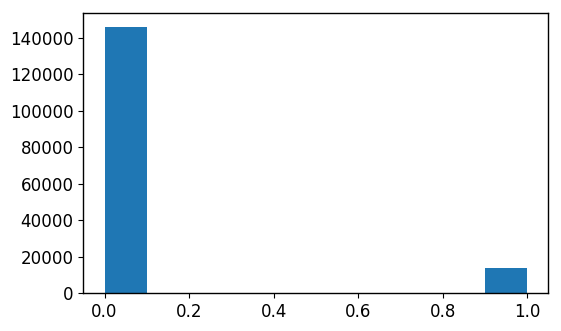

In [9]:
_ = plt.hist(np.where(img_array > 128, 1, 0).flatten())

### Construct TF graph

In [10]:
tf.reset_default_graph()

In [11]:
channels = 1
conv1_fmaps = 5
conv2_fmaps = 10
conv3_fmaps = 15
n_fc = 16
n_outputs = 5

In [12]:
with tf.name_scope('inputs'):
     X = tf.placeholder(dtype=tf.float32, shape=(None, height, width, channels), name="X")
     y = tf.placeholder(dtype=tf.int32, shape=(None), name="y")
     training = tf.placeholder_with_default(False, shape=(None))

In [13]:
dropout_rate_mp = 0.25
dropout_rate_fc = 0.15
#X_drop = tf.layers.dropout(X, dropout_rate, training=training)

In [14]:
conv_1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=4, strides=[4, 4], padding="SAME", activation=tf.nn.relu)
#do_1 = tf.layers.dropout(conv_1, dropout_rate, training=training)
#max_pool_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

conv_2 = tf.layers.conv2d(conv_1, filters=conv2_fmaps, kernel_size=2, strides=[2, 2], padding="SAME", activation=tf.nn.relu)
#do_2 = tf.layers.dropout(conv_2, dropout_rate, training=training)
max_pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

conv_3 = tf.layers.conv2d(max_pool_2, filters=conv3_fmaps, kernel_size=3, strides=[2, 2], padding="SAME", activation=tf.nn.relu)
#do_3 = tf.layers.dropout(conv_3, dropout_rate, training=training)
max_pool_3 = tf.nn.max_pool(conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

with tf.name_scope("fc4"):
     max_pool_3_flat = tf.reshape(max_pool_3, shape=(-1, conv3_fmaps * 6 * 6))
     #inject_target = tf.concat([max_pool_3_flat, tf.cast(tf.reshape(y, shape=(-1, 1)), tf.float32)], axis=1)
     do_4 = tf.layers.dropout(max_pool_3_flat, dropout_rate_mp, training=training)

In [15]:
with tf.name_scope("fully_connected"):
     full_4 = tf.layers.dense(do_4, units=n_fc, activation=tf.nn.relu)
     fc4_drop = tf.layers.dropout(full_4, dropout_rate_fc, training=training)
     logits = tf.layers.dense(fc4_drop, units=n_outputs, activation=None, name='outputs')

In [16]:
with tf.name_scope("loss"):
     xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
     loss = tf.reduce_mean(xentropy, name="loss")

In [17]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [18]:
with tf.name_scope('my_metrics'):
     y_pred = tf.argmax(logits, axis=1)
     cm = tf.confusion_matrix(labels=y, predictions=y_pred, num_classes=n_outputs, dtype=tf.float64)
     accuracy = tf.trace(cm) / tf.reduce_sum(cm)

In [19]:
init = tf.global_variables_initializer()

In [20]:
batch_size = 75
epochs = 1500

In [21]:
X_test, y_test = fetch_batch(testing_file_paths, batch_size=testing_file_paths.size)

In [22]:
batch_acc_lost = []
test_acc_lost = []
with tf.Session() as sess:
     init.run()
     for epoch in xrange(epochs + 1):
          for iteration in range(training_file_paths.size // batch_size):
               X_batch, y_batch = fetch_batch(training_file_paths, batch_size)
               #print max_pool_3.shape
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch, training:True})
          if not (epoch % 1):
               batch_acc = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
               test_acc = accuracy.eval(feed_dict={X:X_test, y:y_test})
               batch_loss = loss.eval(feed_dict={X:X_batch, y:y_batch})
               test_loss = loss.eval(feed_dict={X:X_test, y:y_test})
               batch_acc_lost.append((epoch, batch_acc, batch_loss))
               test_acc_lost.append((epoch, test_acc, test_loss))
               if not (epoch % 10):
                    print epoch, "----------"
                    print "Accuracy (train):", batch_acc
                    print "Accuracy (test):", test_acc
                    print "Loss (train):", batch_loss
                    print "Loss (test):", test_loss

0 ----------
Accuracy (train): 0.186666666667
Accuracy (test): 0.2125
Loss (train): 1.60722
Loss (test): 1.60738
10 ----------
Accuracy (train): 0.293333333333
Accuracy (test): 0.2375
Loss (train): 1.54635
Loss (test): 1.59016
20 ----------
Accuracy (train): 0.306666666667
Accuracy (test): 0.2575
Loss (train): 1.47475
Loss (test): 1.56176
30 ----------
Accuracy (train): 0.453333333333
Accuracy (test): 0.2725
Loss (train): 1.22896
Loss (test): 1.55893
40 ----------
Accuracy (train): 0.613333333333
Accuracy (test): 0.2875
Loss (train): 1.01805
Loss (test): 1.55977
50 ----------
Accuracy (train): 0.853333333333
Accuracy (test): 0.29
Loss (train): 0.704907
Loss (test): 1.62353
60 ----------
Accuracy (train): 0.866666666667
Accuracy (test): 0.3425
Loss (train): 0.567738
Loss (test): 1.66334
70 ----------
Accuracy (train): 0.84
Accuracy (test): 0.3725
Loss (train): 0.54592
Loss (test): 1.61867
80 ----------
Accuracy (train): 0.866666666667
Accuracy (test): 0.375
Loss (train): 0.526512
Loss (

KeyboardInterrupt: 

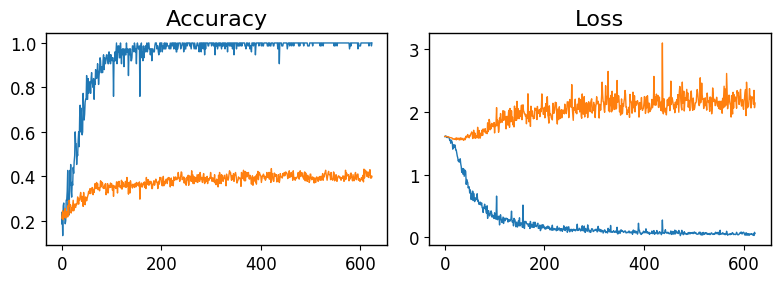

In [23]:
t, acc_b, loss_b = zip(*batch_acc_lost)
t, acc_t, loss_t = zip(*test_acc_lost)

plt.subplots(figsize=(8, 3))
plt.subplot(121)
plt.plot(t, acc_b)
plt.plot(t, acc_t)
plt.title('Accuracy')
plt.subplot(122)
plt.plot(t, loss_b)
plt.plot(t, loss_t)
plt.title('Loss')
plt.tight_layout()